In [1]:
import pandas as pd
import numpy as np
import glob
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict
import scipy
import peakutils
%matplotlib inline
#import mdtraj as md
import parmed as pmd
from decimal import Decimal
import itertools

In [2]:
import seaborn as sns

def set_style():
    # This sets reasonable defaults for font size for
    # a figure that will go in a paper
    sns.set_context("paper")
    
    # Set the font to be serif, rather than sans
    sns.set(font='serif')
    
    # Make the background white, and specify the
    # specific font family
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })
    sns.despine()
    sns.set_style("ticks")
    


set_style()

<Figure size 432x288 with 0 Axes>

In [3]:
def exc_set(x,exclude):
    # Scans list x, returns a list without strings in pick
    check = [i for i in x if not any([e for e in exclude if e in i])]
    return check

def inc_set(x,exclude):
    # Scans list x, returns a list without strings in pick
    check = [i for i in x if any([e for e in exclude if e in i])]
    return check

In [4]:
def turning_points(array):
    ''' turning_points(array) -> min_indices, max_indices
    Finds the turning points within an 1D array and returns the indices of the minimum and 
    maximum turning points in two separate lists.
    '''
    idx_max, idx_min, val_max, val_min = [], [], [], []
    if (len(array) < 3): 
        return idx_min, idx_max

    NEUTRAL, RISING, FALLING = range(3)
    def get_state(a, b):
        if a < b: return RISING
        if a > b: return FALLING
        return NEUTRAL

    ps = get_state(array[0], array[1])
    begin = 1
    for i in range(2, len(array)):
        s = get_state(array[i - 1], array[i])
        if s != NEUTRAL:
            if ps != NEUTRAL and ps != s:
                if s == FALLING: 
                    idx_max.append((begin + i - 1) // 2)
                    # Only register TS higher than 11 kcal/mol
                    if array[i] > 7.5:
                    #if array[i] > 11:
#                        val_max.append("%.2f"%array[i-1])
                        val_max.append(array[i-1])
                else:
                    idx_min.append((begin + i - 1) // 2)
                    if array[i] > 5:
                        val_min.append(array[i-1])
#                        val_min.append("%.2f"%array[i-1])
            begin = i
            ps = s
#    return idx_max, idx_min, val_max, val_min
            
    return val_max[:2]#, val_min[:1]
    #return idx_min, idx_max

In [5]:
def turning_points_idx(array):
    ''' turning_points(array) -> min_indices, max_indices
    Finds the turning points within an 1D array and returns the indices of the minimum and 
    maximum turning points in two separate lists.
    '''
    idx_max, idx_min, val_max, val_min = [], [], [], []
    if (len(array) < 3): 
        return idx_min, idx_max

    NEUTRAL, RISING, FALLING = range(3)
    def get_state(a, b):
        if a < b: return RISING
        if a > b: return FALLING
        return NEUTRAL

    ps = get_state(array[0], array[1])
    begin = 1
    for i in range(2, len(array)):
        s = get_state(array[i - 1], array[i])
        if s != NEUTRAL:
            if ps != NEUTRAL and ps != s:
                if s == FALLING: 
                    
                    # Only register TS higher than 11 kcal/mol
                    #if array[i] > 11:
                    if array[i] > 7.5:
                        val_max.append("%.2f"%array[i-1])
                        idx_max.append((begin + i - 1) // 2)
                else:
                    idx_min.append((begin + i - 1) // 2)
                    if array[i] > 5:
                        val_min.append("%.2f"%array[i-1])
            begin = i
            ps = s
#    return idx_max, idx_min, val_max, val_min
            
    return idx_max[:2]#, val_min[:1]
    #return idx_min, idx_max

In [6]:
def min_points_idx(array):
    ''' turning_points(array) -> min_indices, max_indices
    Finds the turning points within an 1D array and returns the indices of the minimum and 
    maximum turning points in two separate lists.
    '''
    idx_max, idx_min, val_max, val_min = [], [], [], []
    if (len(array) < 3): 
        return idx_min, idx_max

    NEUTRAL, RISING, FALLING = range(3)
    def get_state(a, b):
        if a < b: return RISING
        if a > b: return FALLING
        return NEUTRAL

    ps = get_state(array[0], array[1])
    begin = 1
    for i in range(2, len(array)):
        s = get_state(array[i - 1], array[i])
        if s != NEUTRAL:
            if ps != NEUTRAL and ps != s:
                if s == FALLING: 
                    
                    # Only register TS higher than 11 kcal/mol
                    if array[i] > 11:
                        val_max.append("%.2f"%array[i-1])
                        idx_max.append((begin + i - 1) // 2)
                else:
                    
                    if array[i] > 5:
                        idx_min.append((begin + i - 1) // 2)
                        val_min.append("%.2f"%array[i-1])
            begin = i
            ps = s

    return idx_min[0:1]#, idx_max

In [7]:
# A function that returns the following data in this order
#(0: dfs, 1: rxn_list, 2: energy_list, 3: t_points_precise, 4: t_points_full_idx, 5: leg_list, 6: intermediate_full_idx)
def crunch_data(files):
    # Create DF with all files in files
    dfs = []
    for file in files:
        df = pd.read_csv(file, header=None, delim_whitespace=True, names=['Rxn Coord', 'Energy'])
        dfs.append(df)

    # Convert reaction coord and energy column to lists
    rxn_list, energy_list = [], []
    for df in dfs:
        rxn = df['Rxn Coord'].tolist()
        rxn_list.append(rxn)
        energy = df['Energy'].tolist()
        energy_list.append(energy)

    # T points precise
    t_points_precise = []
    for i in energy_list:
        t_points_precise.append(turning_points(i))

    # T points index
    t_points_full_idx = []
    for i in energy_list:
        t_points_full_idx.append(turning_points_idx(i))    

    # Legend
    leg_list = []
    for i in files:
        leg_list.append(i[-19:-16])

    intermediate_full_idx = []
    for i in energy_list:
        intermediate_full_idx.append(min_points_idx(i))
        
    return(dfs, rxn_list, energy_list, t_points_precise, turning_points_idx, leg_list, intermediate_full_idx)

In [8]:
#Inc only 10^9 V/m completed NEBs

In [9]:
files_0 = glob.glob('../no_field/results/rep_???/neb/kcalnebinfo')
files_0.sort()
files_0

inc = [ 'rep_101', 'rep_102', 'rep_103', 'rep_104', 'rep_105', 'rep_106', 'rep_107', 'rep_108', 'rep_109', 'rep_110', 'rep_111', 'rep_112', 'rep_113', 'rep_114', 'rep_115', 'rep_116', 'rep_117', 'rep_118', 'rep_119', 'rep_120', 'rep_121', 'rep_122', 'rep_123', 'rep_124', 'rep_125' ]
files_0=inc_set(files_0, inc)

In [10]:
## pos x (9) ##
files_px = glob.glob('pos_x_9/rep_???/neb/kcalnebinfo')
files_px.sort()
files_px

files_px=inc_set(files_px, inc)

In [11]:
## neg x (9) ##
files_nx = glob.glob('neg_x_9/rep_???/neb/kcalnebinfo')
files_nx.sort()
files_nx

files_nx=inc_set(files_nx, inc)

In [12]:
files_0, files_px, files_nx

(['../no_field/results/rep_101/neb/kcalnebinfo',
  '../no_field/results/rep_102/neb/kcalnebinfo',
  '../no_field/results/rep_103/neb/kcalnebinfo',
  '../no_field/results/rep_104/neb/kcalnebinfo',
  '../no_field/results/rep_105/neb/kcalnebinfo',
  '../no_field/results/rep_106/neb/kcalnebinfo',
  '../no_field/results/rep_107/neb/kcalnebinfo',
  '../no_field/results/rep_108/neb/kcalnebinfo',
  '../no_field/results/rep_109/neb/kcalnebinfo',
  '../no_field/results/rep_110/neb/kcalnebinfo',
  '../no_field/results/rep_111/neb/kcalnebinfo',
  '../no_field/results/rep_112/neb/kcalnebinfo',
  '../no_field/results/rep_113/neb/kcalnebinfo',
  '../no_field/results/rep_114/neb/kcalnebinfo',
  '../no_field/results/rep_115/neb/kcalnebinfo',
  '../no_field/results/rep_116/neb/kcalnebinfo',
  '../no_field/results/rep_117/neb/kcalnebinfo',
  '../no_field/results/rep_118/neb/kcalnebinfo',
  '../no_field/results/rep_119/neb/kcalnebinfo',
  '../no_field/results/rep_120/neb/kcalnebinfo',
  '../no_field/resul

In [13]:
# Check all the data is there.
for i in np.arange(25):
    print(i+101, files_0[i][-25:-15], files_px[i][-25:-15], files_nx[i][-25:-15])

101 s/rep_101/ 9/rep_101/ 9/rep_101/
102 s/rep_102/ 9/rep_102/ 9/rep_102/
103 s/rep_103/ 9/rep_103/ 9/rep_103/
104 s/rep_104/ 9/rep_104/ 9/rep_104/
105 s/rep_105/ 9/rep_105/ 9/rep_105/
106 s/rep_106/ 9/rep_106/ 9/rep_106/
107 s/rep_107/ 9/rep_107/ 9/rep_107/
108 s/rep_108/ 9/rep_108/ 9/rep_108/
109 s/rep_109/ 9/rep_109/ 9/rep_109/
110 s/rep_110/ 9/rep_110/ 9/rep_110/
111 s/rep_111/ 9/rep_111/ 9/rep_111/
112 s/rep_112/ 9/rep_112/ 9/rep_112/
113 s/rep_113/ 9/rep_113/ 9/rep_113/
114 s/rep_114/ 9/rep_114/ 9/rep_114/
115 s/rep_115/ 9/rep_115/ 9/rep_115/
116 s/rep_116/ 9/rep_116/ 9/rep_116/
117 s/rep_117/ 9/rep_117/ 9/rep_117/
118 s/rep_118/ 9/rep_118/ 9/rep_118/
119 s/rep_119/ 9/rep_119/ 9/rep_119/
120 s/rep_120/ 9/rep_120/ 9/rep_120/
121 s/rep_121/ 9/rep_121/ 9/rep_121/
122 s/rep_122/ 9/rep_122/ 9/rep_122/
123 s/rep_123/ 9/rep_123/ 9/rep_123/
124 s/rep_124/ 9/rep_124/ 9/rep_124/
125 s/rep_125/ 9/rep_125/ 9/rep_125/


In [14]:
# Crunch data
aa = crunch_data(files_nx)
bb = crunch_data(files_0)
cc = crunch_data(files_px)

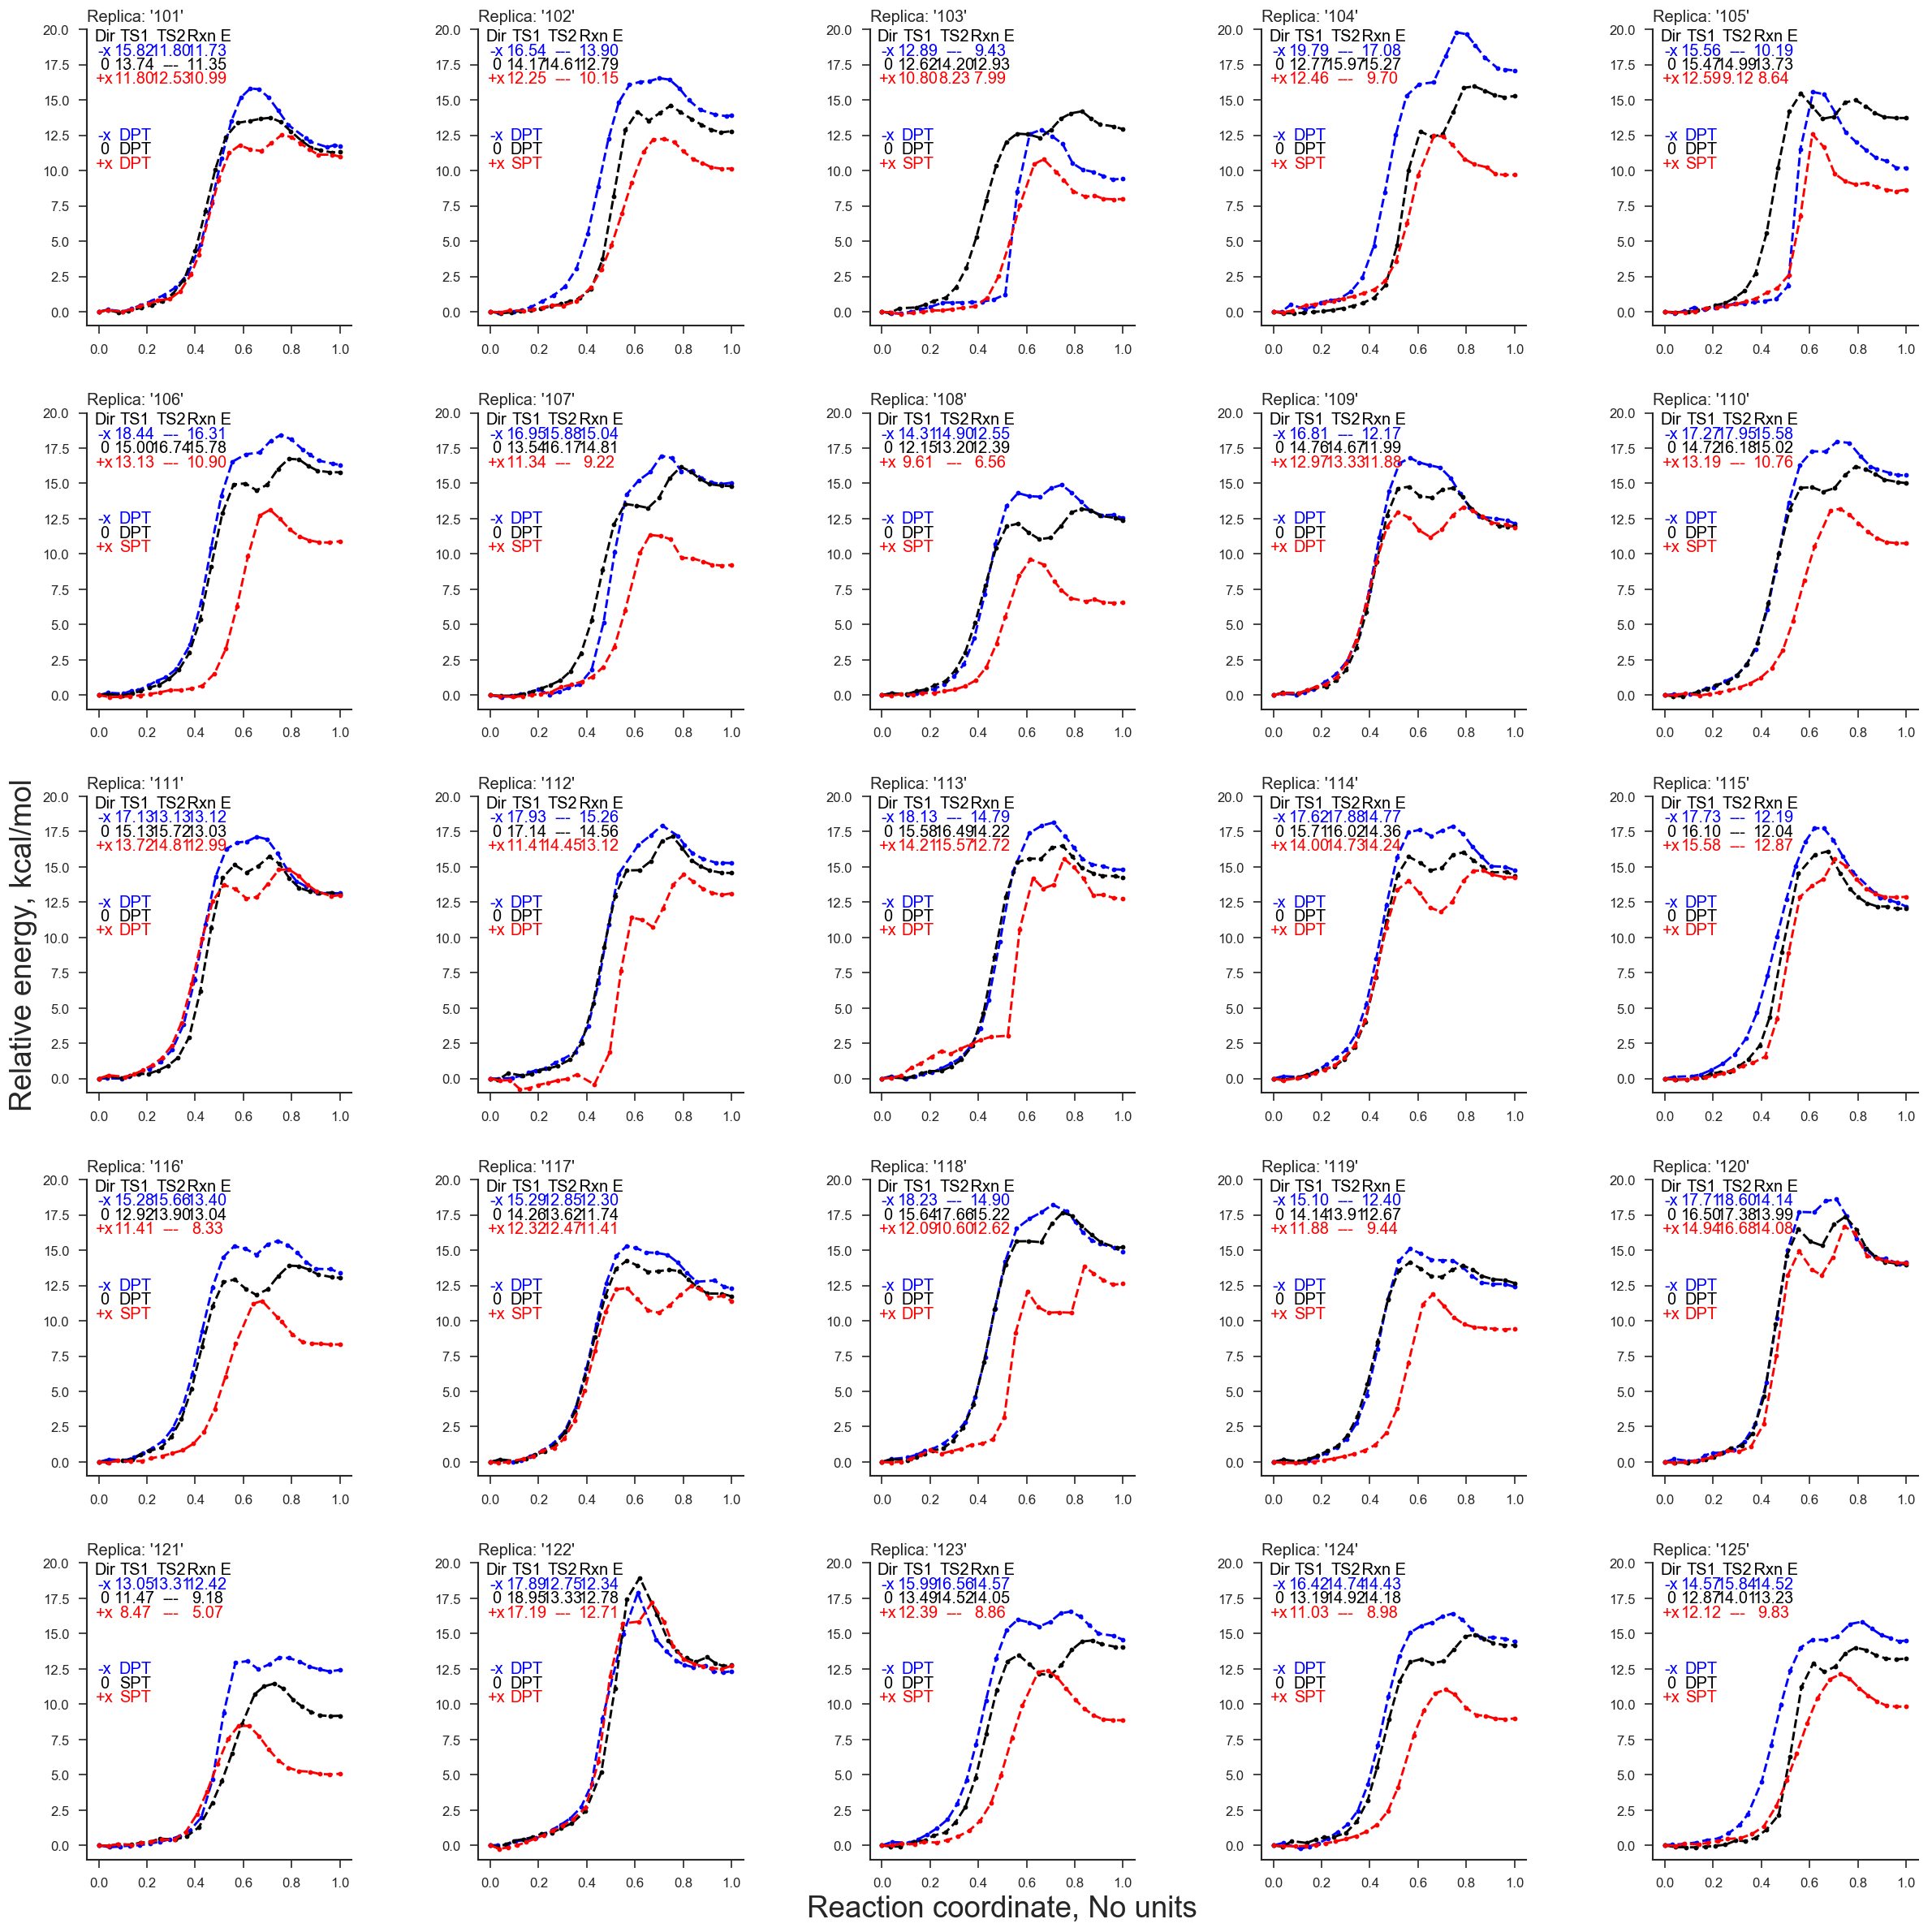

In [15]:
#fig, ax = plt.subplots(dpi=350, figsize=(20,20))
fig, ax = plt.subplots(dpi=120, figsize=(20,20))

nf_color='black'
px_color='red'
nx_color='blue'

num=0
for j in np.arange(len(bb[1])):
    num+=1
    plt.subplot(5,5, num)   
    plt.plot(np.array(aa[1][j])/aa[1][j][-1], aa[2][j], color=nx_color, marker='.', linestyle='dashed')
    plt.plot(np.array(bb[1][j])/bb[1][j][-1], bb[2][j], color=nf_color, marker='.', linestyle='dashed')    
    plt.plot(np.array(cc[1][j])/cc[1][j][-1], cc[2][j], color=px_color, marker='.', linestyle='dashed')
    
    x=0.025
    plt.text(x, 19.5,'Dir', ha='center', va='center',color=nf_color)
    plt.text(x, 18.5,'-x', ha='center', va='center',color=nx_color)  
    plt.text(x, 17.5,'0', ha='center', va='center',color=nf_color)
    plt.text(x, 16.5,'+x', ha='center', va='center',color=px_color)
    #plt.text(x, 16.5,'-x', ha='center', va='center',color=nx_color)   
    
    x=0.15
    plt.text(x, 19.5,'TS1', ha='center', va='center',color=nf_color)
    plt.text(x, 18.5,'%.2f'%aa[3][j][0], ha='center', va='center',color=nx_color)
    plt.text(x, 17.5,'%.2f'%bb[3][j][0], ha='center', va='center',color=nf_color)
    plt.text(x, 16.5,'%.2f'%cc[3][j][0], ha='center', va='center',color=px_color)
    
    x=0.3
    plt.text(x, 19.5,'TS2', ha='center', va='center',color=nf_color)
    if len(bb[3][j])==2:
        plt.text(x, 17.5,'%.2f'%bb[3][j][-1], ha='center', va='center',color=nf_color)
    else:
        plt.text(x, 17.5,'---', ha='center', va='center',color=nf_color)
    if len(cc[3][j])==2:
        plt.text(x, 16.5,'%.2f'%cc[3][j][-1], ha='center', va='center',color=px_color)
    else:
        plt.text(x, 16.5,'---', ha='center', va='center',color=px_color)
    if len(aa[3][j])==2:
        plt.text(x, 18.5,'%.2f'%aa[3][j][-1], ha='center', va='center',color=nx_color)
    else:
        plt.text(x, 18.5,'---', ha='center', va='center',color=nx_color)
    
    x=0.45
    plt.text(x, 19.5,' Rxn E', ha='center', va='center',color=nf_color)
    plt.text(x, 17.5,'%.2f'%bb[2][j][-1], ha='center', va='center',color=nf_color)
    plt.text(x, 16.5,'%.2f'%cc[2][j][-1], ha='center', va='center',color=px_color)
    plt.text(x, 18.5,'%.2f'%aa[2][j][-1], ha='center', va='center',color=nx_color)    
    
    # Axis
    plt.ylim(-1,20)
    
    # Titles
    plt.title('Replica: %r' %(bb[5])[j], loc='left')
    
    x=0.025
    plt.text(x, 12.5,'-x', ha='center', va='center',color=nx_color)
    plt.text(x, 11.5,'0', ha='center', va='center',color=nf_color)
    plt.text(x, 10.5,'+x', ha='center', va='center',color=px_color)

    
    x=0.15
    # No field
    if int(cc[5][j]) not in [121]:
        plt.text(x, 11.5, 'DPT', ha='center', va='center',color=nf_color)
    else:
        plt.text(x, 11.5,'SPT', ha='center', va='center',color=nf_color)    
    # pos x
    if int(cc[5][j]) in [101, 109, 111, 112 ,113, 114,115,118,120,122]:
        plt.text(x, 10.5, 'DPT', ha='center', va='center',color=px_color)
    else:
        plt.text(x, 10.5,'SPT', ha='center', va='center',color=px_color)
    # neg x
    if int(cc[5][j]) in [101, 102, 103, 104, 105, 106, 107,108,109,110,111, 112, 113, 114,115,116,117,118,119,120,121,122,123,124,125]:
        plt.text(x, 12.5, 'DPT', ha='center', va='center',color=nx_color)
    #else:
    #    plt.text(x, 12.5,'-x SPT', ha='center', va='center',color=nx_color)
        
    
    if int(cc[5][j]) in [123]:
        plt.xlabel('Reaction coordinate, No units', size=22)
        
    if int(cc[5][j]) in [111]:
        plt.ylabel('Relative energy, kcal/mol', size=22)
        
# General graph layouts
sns.despine()
plt.tight_layout()

plt.show()